In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import xgboost
import mlflow.sklearn
import mlflow.pyfunc
import logging
import warnings
from sklearn.model_selection import train_test_split , cross_val_score , GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials , space_eval , STATUS_FAIL  , SparkTrials , rand

# Data Set > https://www.kaggle.com/datasets/joebeachcapital/credit-card-fraud/code 

The resources for this dataset can be found at https://www.openml.org/d/1597

Author: Andrea Dal Pozzolo, Olivier Caelen and Gianluca Bontempi  
Source: Credit card fraud detection - Date 25th of June 2015  
Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015  

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset present transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML.

In [2]:
df = pd.read_csv("/mnt/80d0394e-e324-4985-a982-66c9f2d7a327/Credit_Card_Fraud_Detection_Using_ML/Data/archive/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


In [3]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [4]:
df.Class.value_counts()

Class
'0'    284315
'1'       492
Name: count, dtype: int64

In [5]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class      object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
print ("number of rows in dataset is: ", df.shape[0])
print ("number of columns in dataset is: ", df.shape[1])
df['Class'].unique()

number of rows in dataset is:  284807
number of columns in dataset is:  31


array(["'0'", "'1'"], dtype=object)

# Data Visualization

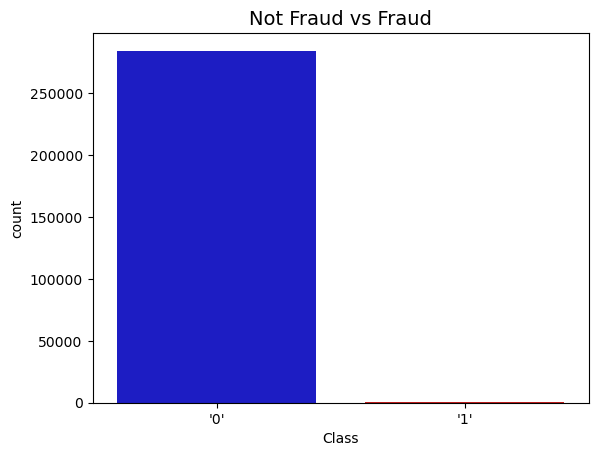

In [8]:
colors = ["#0101DF", "#DF0101"]
sns.countplot(x ='Class', data=df , palette=colors)
plt.title ('Not Fraud vs Fraud' , fontsize=14)
plt.show()

In [9]:
# we do not need the Time column because it is highly unlikely that time is a viable feature in this model, so we drop it
# the Amount column, however, could be indicative of fraud (although it is debatable)
df = df.drop(['Time'], axis = 1)

In [10]:
# let us drop all the duplicates from the sample
df = df.drop_duplicates()

In [11]:
df.count()

V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount    275663
Class     275663
dtype: int64

In [12]:
df['Class'] = df['Class'].str.strip("'")
df['Class'] = df['Class'].astype(int)
df.Class

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 275663, dtype: int64

In [13]:
df.Class.value_counts()

Class
0    275190
1       473
Name: count, dtype: int64

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

In [16]:
x = df.drop('Class', axis=1)
y = df.Class

standard_scaler = StandardScaler()
x = standard_scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Model

In [21]:
models = {
    'LogisticRegression': LogisticRegression(n_jobs=-1),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'SVC': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
    'CatBoostClassifier': CatBoostClassifier(),
    'XGBClassifier': xgboost.XGBClassifier(n_jobs=-1)
    
}

In [22]:
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print (f"{name} Metrics:")
    print (f"Accuracy: {accuracy:.2f}")
    print (f"Precision: {precision:.2f}")
    print (f"Recall: {recall:.2f}")
    print (f"F1-Score: {f1:.2f}")
    print ('-' * 40)


LogisticRegression Metrics:
Accuracy: 1.00
Precision: 0.86
Recall: 0.58
F1-Score: 0.70
----------------------------------------
DecisionTreeClassifier Metrics:
Accuracy: 1.00
Precision: 0.67
Recall: 0.78
F1-Score: 0.72
----------------------------------------
RandomForestClassifier Metrics:
Accuracy: 1.00
Precision: 0.91
Recall: 0.75
F1-Score: 0.83
----------------------------------------
SVC Metrics:
Accuracy: 1.00
Precision: 0.96
Recall: 0.64
F1-Score: 0.77
----------------------------------------
KNeighborsClassifier Metrics:
Accuracy: 1.00
Precision: 0.90
Recall: 0.76
F1-Score: 0.83
----------------------------------------
Learning rate set to 0.100375
0:	learn: 0.3555519	total: 125ms	remaining: 2m 5s
1:	learn: 0.1985544	total: 181ms	remaining: 1m 30s
2:	learn: 0.1074300	total: 220ms	remaining: 1m 13s
3:	learn: 0.0597708	total: 258ms	remaining: 1m 4s
4:	learn: 0.0355088	total: 298ms	remaining: 59.2s
5:	learn: 0.0223711	total: 337ms	remaining: 55.8s
6:	learn: 0.0152860	total: 378ms	